# Arima Models (Core)
by Hikmat Ashqar 


## Imports 

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
from sklearn import set_config
set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)



## Custom Functions


In [8]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [9]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [11]:

def get_sig_lags(ts, type='ACF', nlags=None, alpha=0.5):
    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)
    elif type == 'PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)
    else: 
        raise Exception("type must be either 'ACF' or 'PACF'")
        
    # Determine lags
    lags = range(len(corr_values))
    
    # Create a centered version of the acf_df 
    corr_df = pd.DataFrame({
        type: corr_values,
        'Lags': lags,
        'lower ci': conf_int[:, 0] - corr_values, # subtract acf from lower ci to center
        'upper ci': conf_int[:, 1] - corr_values, # subtract acf from upper ci to center
    })
    corr_df = corr_df.set_index("Lags")
    
    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s 
    sig_lags = corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags != 0]

    return sig_lags

In [12]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig



## Load Data


In [39]:
# Load in stock data
ts = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()



,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


<Axes: xlabel='Date'>

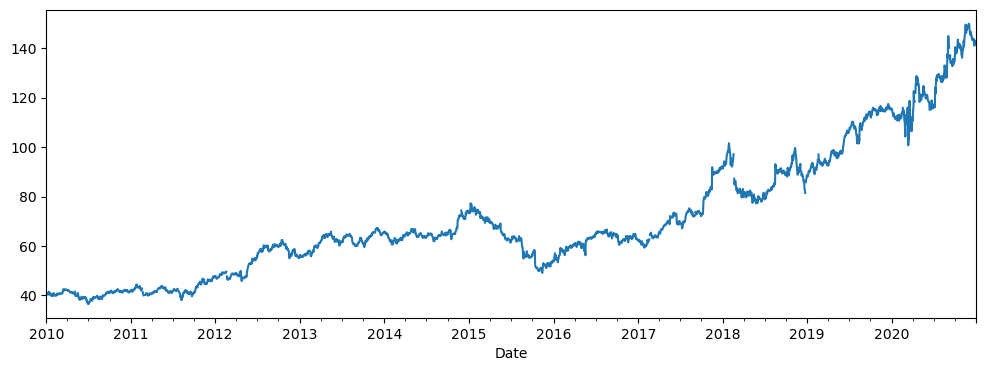

In [40]:

ts = ts.loc['2010 ':'2020 ', 'Adj Close']
ts.plot()


In [41]:
# Preview the index
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [42]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [43]:
# Check for nulls
ts.isna().sum()

101

In [44]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
2011-02-21   NaN
2011-04-22   NaN
2011-05-30   NaN
2011-07-04   NaN
2011-09-05   NaN
2011-11-24   NaN
2011-12-26   NaN
2012-01-02   NaN
2012-01-16   NaN
2012-02-20   NaN
Name: Adj Close, dtype: float64

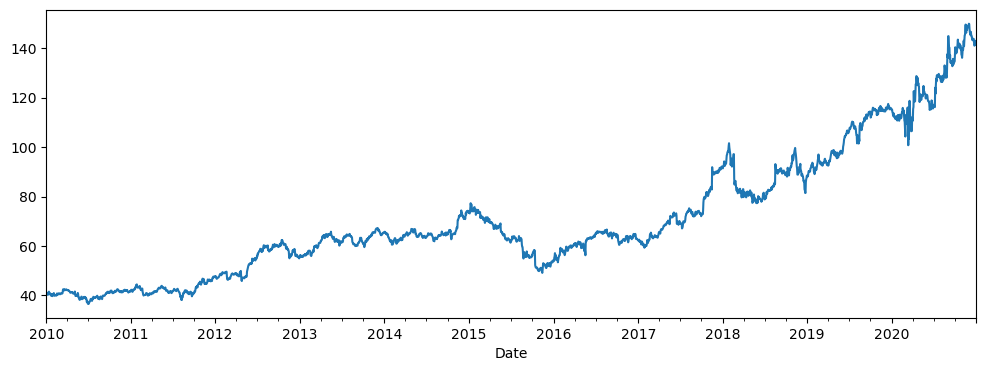

In [45]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();



In [46]:
ts.isna().sum()

1

In [47]:
# Get the value for the date just before 1-1-2015
ts1 = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')

previous_record = ts1.loc['2009-12-31']

In [48]:
previous_record[0]

40.374447

In [51]:
ts.head()

Date
2010-01-01    40.374447
2010-01-04    40.963638
2010-01-05    40.555729
2010-01-06    40.465084
2010-01-07    40.487759
Freq: B, Name: Adj Close, dtype: float64

In [50]:
ts = ts.fillna(previous_record[0])


## Check for Stationarity



In [55]:
# Testing the raw data for stationarity
get_adfuller_results(ts)



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457409,23,2846,0.99736,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.214006,22,2846,0.0,0.05,True


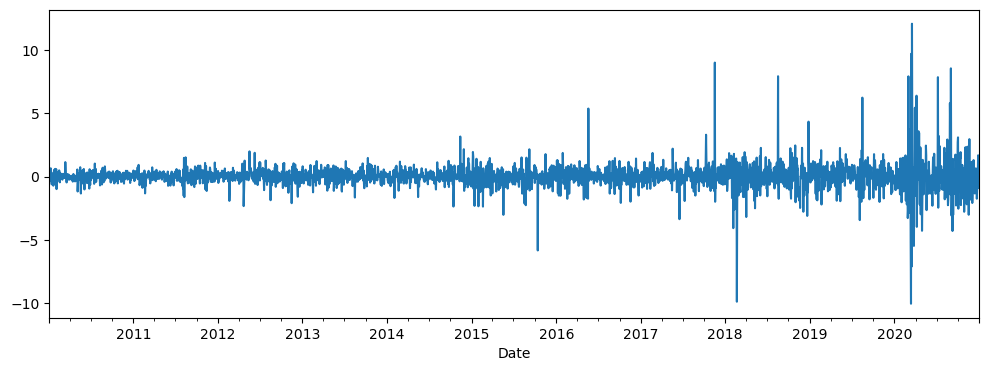

In [60]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)



In [61]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')


d is 1


## Interpreting ACF and PACF​


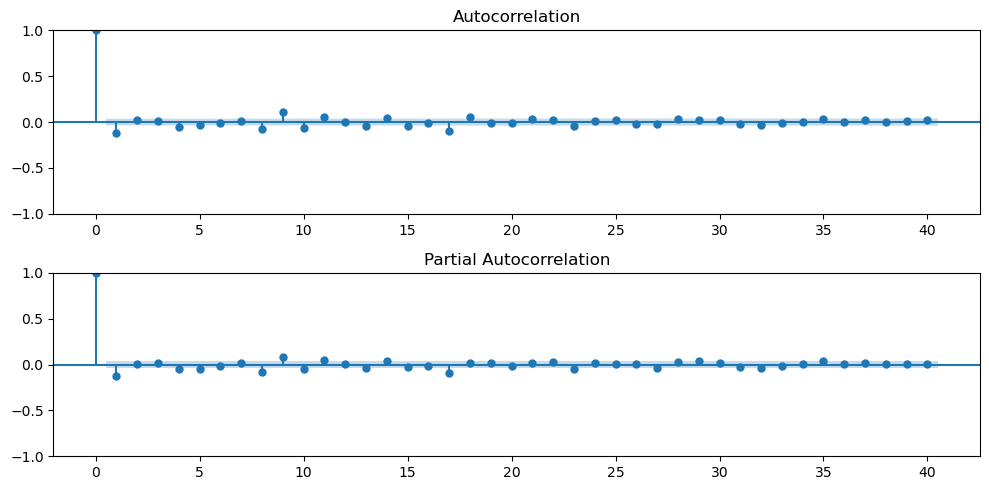

In [62]:
plot_acf_pacf(ts_diff);


We see a gradual decrease in the PACF and a sharp drop after lag 1 on the ACF, so we will try an MA(1) model. 

## ​Train Test Split



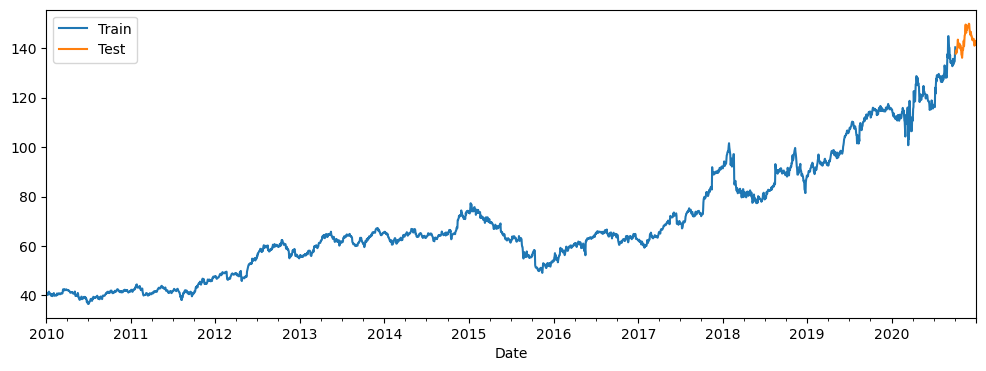

In [63]:
# Calculating number of test lags
n_test_lags = 65  

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();



## Fit and Evaluate



In [64]:
# Build the model 
p = 1  # AR component 

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()



------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.744
- MSE = 22.321
- RMSE = 4.725
- R^2 = -0.736
- MAPE = 2.57%


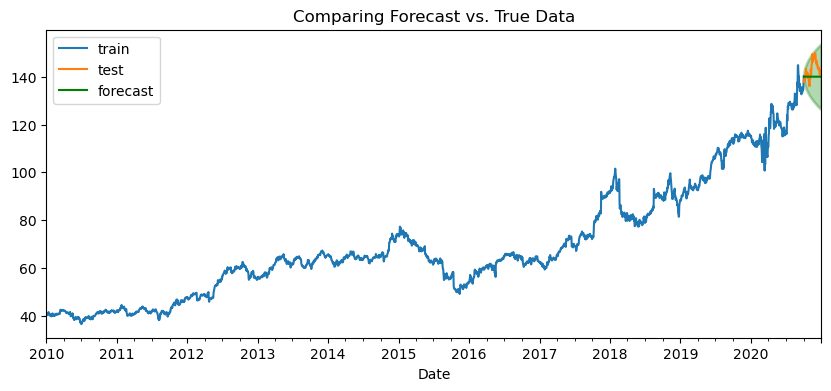

In [65]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



## ​Model Summary and Diagnostics Plots



In [66]:
# Obtain summary of model
arima_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3888.615
Date:                Mon, 10 Jun 2024   AIC                           7783.231
Time:                        22:31:29   BIC                           7801.047
Sample:                    01-01-2010   HQIC                          7789.661
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1804      0.050     -3.634      0.000      -0.278      -0.083
ma.L1          0.0618      0.052      1.187      0.235      -0.040       0.164
sigma2         0.9377      0.006    146.460      0.000       0.925       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            113869.13
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              10.46   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

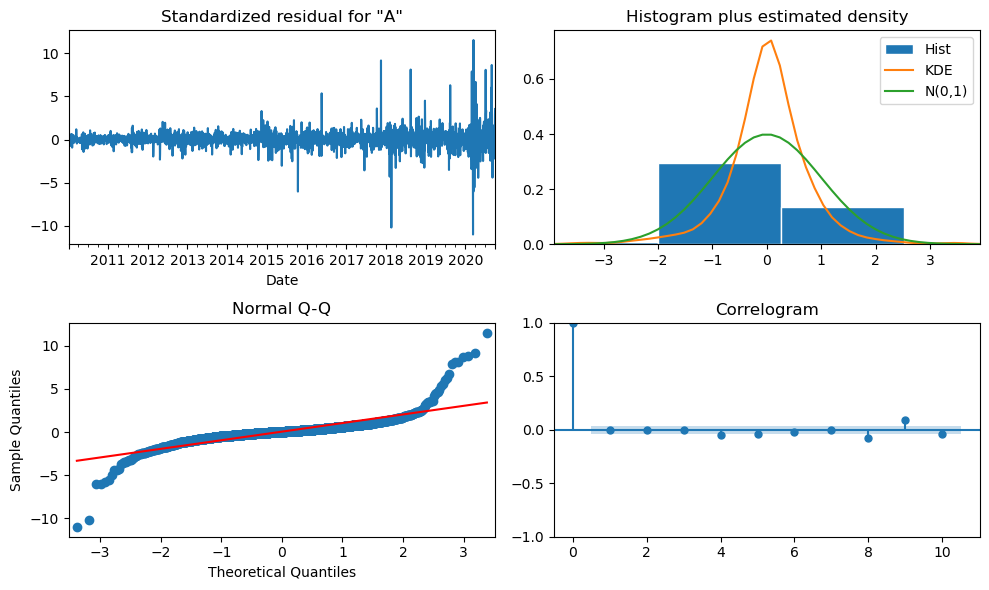

In [67]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



In [72]:
# Calculate MAPE
# Make forecasts
# forecast = arima_model.forecast(steps=len(test))
# mape = mean_absolute_percentage_error(test, forecast)
# print(f'MAPE: {mape}')

MAPE: 0.02573961951763979


## Loop to Try Different Orders


In [68]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [1]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try



[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [69]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)



(0, 1, 0) 7819.573414955272
(0, 1, 1) 7782.568450003508
(0, 1, 2) 7783.239842404086
(0, 1, 3) 7784.910104390019
(1, 1, 0) 7781.407088472942
(1, 1, 1) 7783.230521609743
(1, 1, 2) 7784.030164429405
(1, 1, 3) 7780.326580871766
(2, 1, 0) 7783.2142220706355
(2, 1, 1) 7785.21275148793


C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7785.389282341344
(2, 1, 3) 7771.324332004055
(3, 1, 0) 7785.193057160317
(3, 1, 1) 7787.214160907015


C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7774.975880602276
(3, 1, 3) 7781.06439550367
Best AIC: 7771.324332004055
Best pdq: (2, 1, 3)


In [73]:
# Build the model with the best AIC
p = 2  # AR component 

d = 1  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()



In [74]:
# Obtain summary of model
ar_2_ma_3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3879.662
Date:                Mon, 10 Jun 2024   AIC                           7771.324
Time:                        22:35:14   BIC                           7806.957
Sample:                    01-01-2010   HQIC                          7784.185
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5164      0.042     35.809      0.000       1.433       1.599
ar.L2         -0.8594      0.042    -20.642      0.000      -0.941      -0.778
ma.L1         -1.6399      0.044    -37.373      0.000      -1.726      -1.554
ma.L2          1.0655      0.045     23.479      0.000       0.977       1.154
ma.L3         -0.1412      0.007    -19.946      0.000      -0.155      -0.127
sigma2         0.9318      0.007    133.683      0.000       0.918       0.945
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            106820.65
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              10.31   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

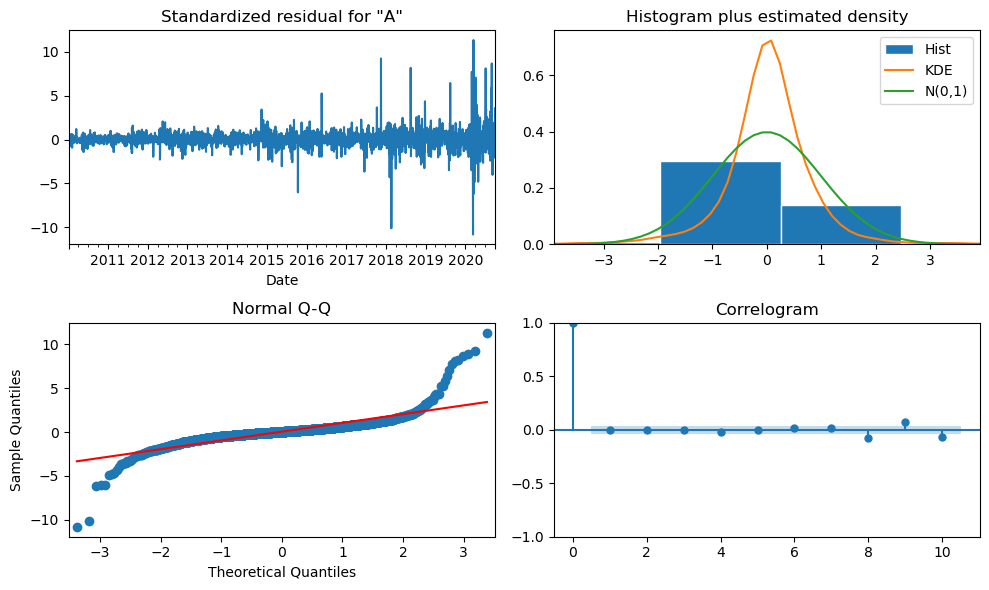

In [75]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.144
- MSE = 26.200
- RMSE = 5.119
- R^2 = -1.037
- MAPE = 2.85%


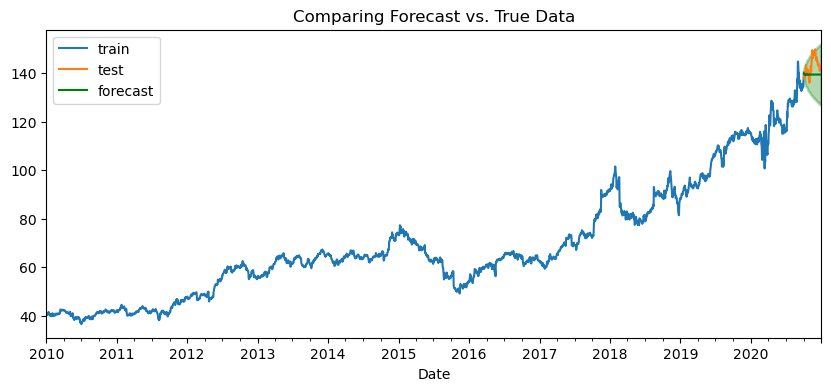

In [76]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



The metrics are very similar between the two models, but the ARIMA(2,1,3) performs slightly better in each case. We will choose this as our model based on the evaluation metrics, the significant coefficients, the AIC score, and the improved residuals correlogram.

C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hekmat.ashqar\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

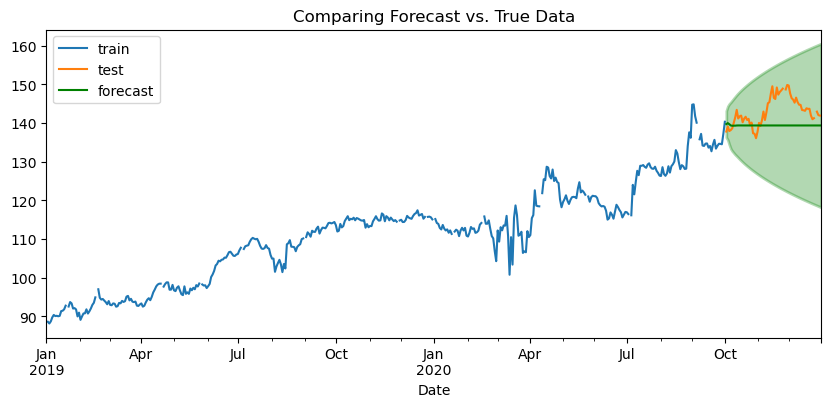

In [84]:
# Load in stock data
ts = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
# Adjusting the range of the training data
ts = ts.loc['2019':'2020', 'Adj Close']  # Change this range to a more recent period as needed

# Calculating number of test lags
n_test_lags = 65  

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)

# Fit the ARIMA model (assuming you have already fit an ARIMA model and named it `arima_model`)
arima_model = tsa.ARIMA(train, order=(5,1,0)).fit()  # Adjust the order as needed

# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)